In [2]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
from sklearn.utils import shuffle

print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [3]:
# 1 Reload the preprocessed data

pickle_file = './pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 Model Architecture

## 2.1 Inception model and GoogLeNet

In [4]:
def Inception(inputs, conv11_size, conv33_11_size, conv33_size,conv55_11_size, conv55_size, pool11_size):
    conv11 = layers.conv2d(inputs, conv11_size, [1, 1])
    conv33_reduce = layers.conv2d(inputs, conv33_11_size, [1, 1])
    conv33 = layers.conv2d(conv33_reduce, conv33_size, [3, 3])
    conv55_reduce = layers.conv2d(inputs, conv55_11_size, [1, 1])
    conv55 = layers.conv2d(conv55_reduce, conv55_size, [5, 5])
    pool_proj = layers.max_pool2d(inputs, [3, 3], stride = 1, padding='SAME')
    pool11 = layers.conv2d(pool_proj, pool11_size, [1, 1])
    return tf.concat([conv11, conv33, conv55, pool11], 3)

def GoogLeNet(inputs, dropout_keep_prob): # inputs size:32x32x3
    conv1 = layers.conv2d(inputs, 64, [3, 3], stride = 2) # 16x16x64
    
    inception_2a = Inception(conv1, 64, 96, 128, 16, 32, 32) # 16x16x256
    inception_2b = Inception(inception_2a, 128, 128, 192, 32, 96, 64) # 16x16x480
    pool2 = layers.max_pool2d(inception_2b, [3, 3]) # 7x7x480 ? why
    
    inception_3a = Inception(pool2, 192, 96, 208, 16, 48, 64) # 7x7x512
    inception_3b = Inception(inception_3a, 160, 112, 224, 24, 64, 64) # 7x7x512
    pool3 = layers.max_pool2d(inception_3b, [3, 3]) # 3x3x512
    
    inception_4a = Inception(pool3, 256, 160, 320, 32, 128, 128) # 3x3x832
    inception_4b = Inception(inception_4a, 384, 192, 384, 48, 128, 128) # 3x3x1024
    pool4 = layers.avg_pool2d(inception_4b, [3, 3], stride = 1) 

    reshape = tf.reshape(pool4, [-1, 1024])
    dropout = layers.dropout(reshape, dropout_keep_prob)
    logits = layers.fully_connected(dropout, 43, activation_fn=None)
    
    return logits

# 3 Training

## 3.1 Strategy

In [5]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 4e-4
EPOCHS = 25
BATCH_SIZE = 128

# Train method
logits = GoogLeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 3.2 Evaluation

In [6]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
%%time
saver = tf.train.Saver()
train_accuracy = []
valid_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            total_train_acc += (train_acc * len(batch_x))
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Validation Accuracy = {:.3f}".format(valid_acc))
        
    saver.save(sess, './model3/googlenet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.423
EPOCH 2 : Validation Accuracy = 0.889
EPOCH 3 : Validation Accuracy = 0.932
EPOCH 4 : Validation Accuracy = 0.911
EPOCH 5 : Validation Accuracy = 0.940
EPOCH 6 : Validation Accuracy = 0.963
EPOCH 7 : Validation Accuracy = 0.958
EPOCH 8 : Validation Accuracy = 0.967
EPOCH 9 : Validation Accuracy = 0.962
EPOCH 10 : Validation Accuracy = 0.948
EPOCH 11 : Validation Accuracy = 0.964
EPOCH 12 : Validation Accuracy = 0.946
EPOCH 13 : Validation Accuracy = 0.971
EPOCH 14 : Validation Accuracy = 0.968
EPOCH 15 : Validation Accuracy = 0.970
EPOCH 16 : Validation Accuracy = 0.978
EPOCH 17 : Validation Accuracy = 0.979
EPOCH 18 : Validation Accuracy = 0.969
EPOCH 19 : Validation Accuracy = 0.963
EPOCH 20 : Validation Accuracy = 0.971
EPOCH 21 : Validation Accuracy = 0.983
EPOCH 22 : Validation Accuracy = 0.975
EPOCH 23 : Validation Accuracy = 0.980
EPOCH 24 : Validation Accuracy = 0.977
EPOCH 25 : Validation Accuracy = 0.980
Model saved
Wall time:

#### Plot the accuracy of training and validation operation

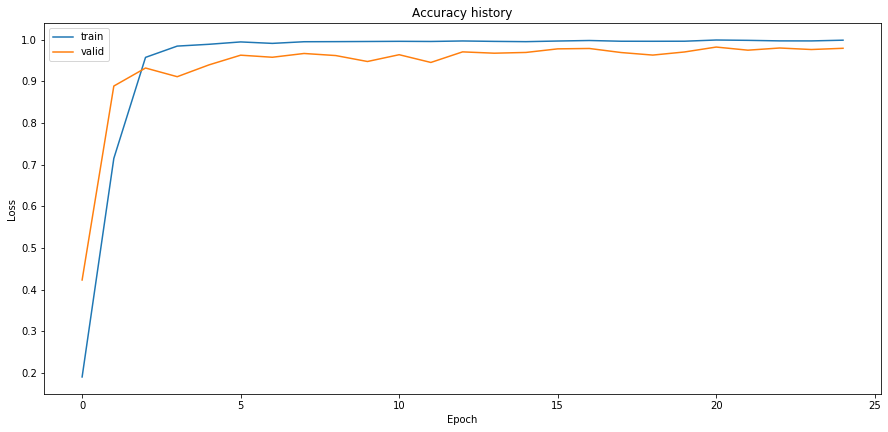

In [8]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.show()

# 4 Testing

## 4.1 Test the model on testing dataset

In [3]:
saver = tf.train.import_meta_graph('./model3/googlenet.ckpt.meta')
with tf.Session() as sess:
    saver.restore(sess, './model3/googlenet.ckpt')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model3/googlenet.ckpt


INFO:tensorflow:Restoring parameters from ./model3/googlenet.ckpt


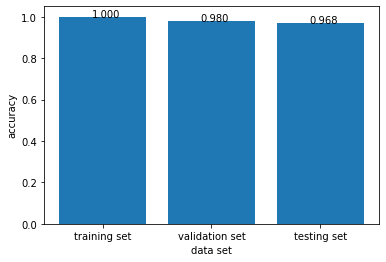

In [10]:
with tf.Session() as sess:
    saver.restore(sess, './model3/googlenet.ckpt')
#     sess.run(tf.global_variables_initializer())
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

## 4.2 Test the Model on New Images

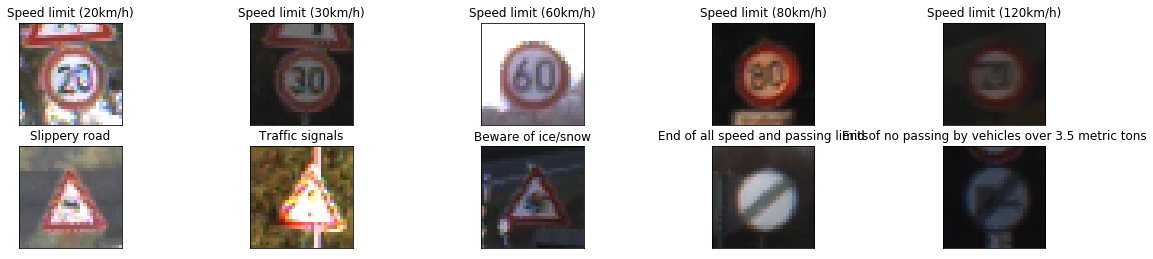

In [11]:
gt_images = []
gt_labels = []

with open('./test_images/labels.csv') as f:
    gt_labels = [row[7] for row in csv.reader(f)]
# print(gt_labels)

for i in range(1, 11):
    img = Image.open('./test_images/' + str(i) +'.ppm')
    img.save('./test_images/' + str(i) +'.jpg')
    gt_images.append(plt.imread('./test_images/' + str(i) +'.ppm'))
# print(gt_images)

plt.figure(figsize=(20, 20))
for i in range(len(gt_images)):
    plt.subplot(9, 5, i + 1), plt.imshow(gt_images[i]), plt.title(signnames[int(gt_labels[i])])
    plt.xticks([]), plt.yticks([])
    
gt_images = np.array(gt_images)
gt_labels = np.array(gt_labels)
    
# Normalization
gt_images = gt_images.astype(np.float32) / 128. - 1.

### Predict the Sign Type for Each Image

In [15]:
with tf.Session() as sess:
    saver.restore(sess, './model3/googlenet.ckpt')
    test_accuracy = evaluate(gt_images, gt_labels)
    #print("Test Accuracy = {:.3f}".format(test_accuracy))   
    logits_value = sess.run(logits, feed_dict={x: gt_images})
    probabilities = sess.run(tf.nn.softmax(logits_value))
    
predict = probabilities.argmax(axis=1)
print("Predict the Sign Type for Each Image")
print(predict)

INFO:tensorflow:Restoring parameters from ./model3/googlenet.ckpt
Predict the Sign Type for Each Image
[ 0  1  3  5  8 23 26 30 32 42]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

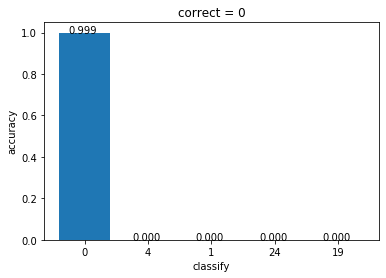

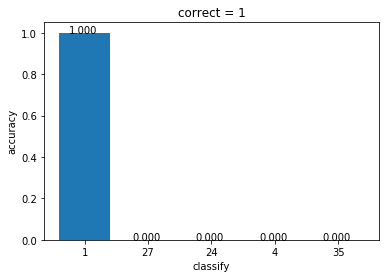

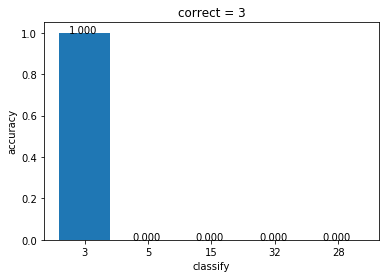

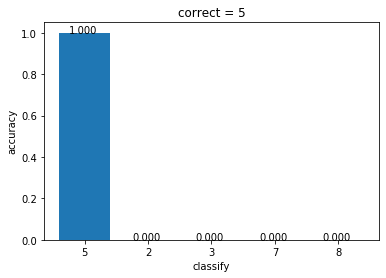

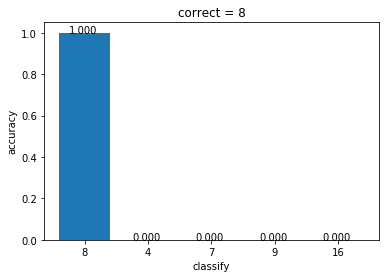

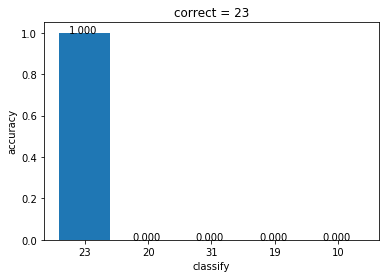

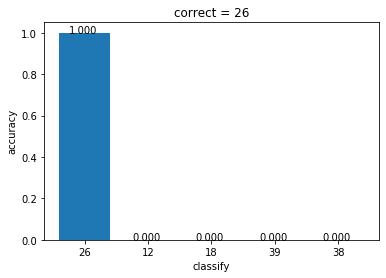

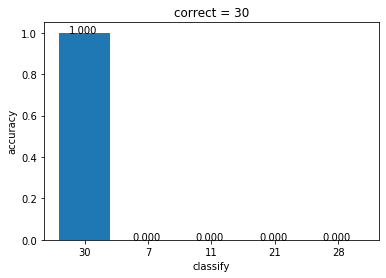

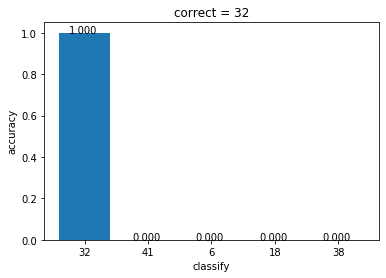

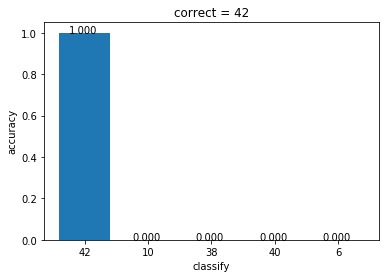

In [16]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(probabilities), k=5))

def plt_bar(values, indicex, answer):
    plt.bar(range(5), values)
    plt.xlabel('classify')
    plt.ylabel('accuracy')
    plt.xticks(range(5), indicex)
    plt.title("correct = "+answer)
    for x_,y_ in zip(range(5), values):
        plt.text(x_ - 0.25, y_, '%.3f'%y_)
    plt.show()

for i in range(10):
    plt_bar(top5.values[i], top5.indices[i], gt_labels[i])

## Accuracy for predicting unknown images from Web

In [17]:
gt_labels

array(['0', '1', '3', '5', '8', '23', '26', '30', '32', '42'], dtype='<U2')

In [18]:
predict

array([ 0,  1,  3,  5,  8, 23, 26, 30, 32, 42], dtype=int64)

In [19]:
cnt=0
for i in range(predict.size):
    if int(gt_labels[i]) == predict[i]:
        cnt = cnt+1

pred_acc = (cnt/predict.size)*100
print("Accuracy for Predicting unknown images from web:",pred_acc,"%")

Accuracy for Predicting unknown images from web: 100.0 %
